# Setup
## Imports

In [1]:
import os
from os import environ
from os.path import join
import json

# # geoprocessing imports
import geopandas as gpd
import pandas as pd
import numpy as np

# Functions definition

In [2]:
# Functions
def import_csv(csv_path, *columns_names, freq='1MS', aggfunc='mean'):
    """Import a CSV with the correct format and export a monthly time series per district

    Args:
        csv_path (str): The path to the CSV file
        columns_names (str): Name of the column with the time-series variable
        freq (str, Optional): The frequency of aggregation
        aggfunc (str, Optional): The aggregation function for the monthly resampling. Defaults to 'mean'.
        
    Returns:
        pd.DataFrame: The formatted DataFrame
    """
    df = pd.read_csv(csv_path, index_col=0, parse_dates=['month'])
    df = df[[*columns_names, 'month', 'district']].set_index('month')
    return df.groupby([pd.Grouper(freq=freq), 'district']).agg(aggfunc)

## Parameters

In [3]:
# main path
data_folder = '../data'

# paths
aoi_path = join(data_folder, 'admin', 'adm2.geojson')
indicators_path = join(data_folder, 'indicators')

# Main code

## Load all the indicators values

In [4]:
source_colname_dict = {
    'population': 'sum',
    'ndvi': 'mean',
    'cropmask': 'sum',
    'precipitations': 'mean',
    'temperature': 'mean',
    'waterlevels': 'mean',
    'waterextent': 'sum',
}

# define start and end dates
start_date = np.datetime64('2020-01-01')
end_date = np.datetime64('2025-12-31')

# load the AOI
aoi_gdf = gpd.read_file(aoi_path)

# then load other df and join them to concat_df
df_list = []
for source, colname in source_colname_dict.items():
    freq= '1YS' if source in ('cropmask', 'waterextent') else '1MS'
    df = import_csv(os.path.join(data_folder, 'indicators', f"{source}.csv"), colname, freq=freq) # load the df
    df = df[(df.index.get_level_values(0) >= start_date)&(df.index.get_level_values(0) <= end_date)] # filter on dates
    df = df.rename(columns={colname: source}) # rename the column with monthly value

    # concat_df = concat_df.join(df, how='outer') # join to concat_df
    df_list.append(df)

# concatenate everything
concat_df = pd.concat(df_list, axis=1)
concat_df = concat_df.fillna({'events_count': 0})

# generate 'month', 'month_dt' column
concat_df = concat_df.reset_index().rename(columns={'month': 'month_dt'})
concat_df['month'] = concat_df['month_dt'].dt.strftime("%m").astype(int)

# sort values
concat_df = concat_df.sort_values(['month_dt', 'district']).reset_index(drop=True)

In [5]:
# generate a monthly average per district for each indicator on previous years
monthly_avg_df = (
    concat_df
        .reset_index(drop=True)
        .loc[concat_df['month_dt'].dt.year < 2024, :]
        .drop(columns=['month_dt'])
        .groupby(['month', 'district']).agg(['mean', 'std'])
        .reset_index()
)

# generate yearly population and displaced df
yearly_population_df = (
    concat_df
        .loc[:, ['month_dt', 'district', 'population']]
        .set_index('month_dt')
        .groupby(['district', pd.Grouper(freq='1YS')]).min()
        .fillna({'population': 0})
        .reset_index()
)

# Convert Shape__Area (in square meters) to square miles and calculate population density
# 1 square mile = 2,589,988.11 square meters
SQ_METERS_PER_SQ_MILE = 2589988.11

yearly_population_df['population_density'] = (
    yearly_population_df
        .merge(aoi_gdf[['district', 'Shape__Area']], on='district')
        .apply(lambda x: x['population'] / (x['Shape__Area'] / SQ_METERS_PER_SQ_MILE), axis=1)
)

## Calculate indicators

In [7]:
layer_list = ['waterlevels', 'precipitations', 'temperature', 'ndvi', 'waterextent']
curr_year = concat_df['month_dt'].dt.year.unique()[-1]

ts_year_df = (
    concat_df
        .assign(year=lambda x: x['month_dt'].dt.year)
        .loc[:, layer_list + ['year', 'month', 'district']]
        .set_index(['year', 'month', 'district'])
)

# ts_avg_df = concat_df.loc[concat_df['month_dt'].dt.year < curr_year, layer_list + ['month', 'district']]\
#                     .groupby(['month', 'district']).agg('mean') # avg per district

ts_avg_df = (
    concat_df
        .loc[concat_df['month_dt'].dt.year < curr_year, layer_list + ['month']]
        .groupby(['month']).agg('mean') # avg independante of the district
)

ind_df = (
    ((ts_year_df-ts_avg_df)/ts_avg_df)
        .reset_index()
        .groupby(['year', 'district']).mean()
        .assign(
            water=lambda x: (x['waterlevels']+x['waterextent']/100),
            climate=lambda x: (x['precipitations']-x['temperature'])/2,
            agriculture=lambda x: x['ndvi']
        ).fillna({'water': 0})
        .drop(columns=layer_list+['month'])
        .reset_index()
)

ind_df = ind_df.groupby('district').mean().reset_index().drop(columns='year')
# ind_df = ind_df[ind_df['year']==2024].drop(columns='year')

In [8]:
ind_list = ['climate', 'agriculture', 'water']
ind_min, ind_max = ind_df[ind_list].min(), ind_df[ind_list].max()
th = ind_df[ind_list].mean(), ind_df[ind_list].mean()+2*ind_df[ind_list].std()

for indicator in ind_list:
    # normalize all values from 0 to 1
    ind_df[indicator+'_norm'] = (ind_df[indicator] - ind_min[indicator]) / (ind_max[indicator] - ind_min[indicator])
    
    # method 1: normalize between 0-2
    # (ind_df[indicator] * 2).astype(int)

    # method 2: rule based intervals
    ind_df[indicator+'_levels'] = (
        ind_df[indicator+'_norm']
            .apply(lambda x: 0 if x < th[0][indicator] else 1 if x < th[1][indicator] else 2)
            .astype(int)
    )

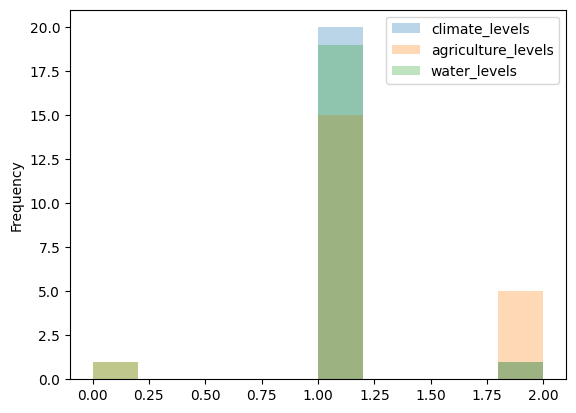

In [9]:
ind_df[[i+'_levels' for i in ind_list]].plot.hist(alpha=0.3);

## Generate JSON

In [10]:
## Generate and export the JSON files
layer_aggfunc_dict = {
    'waterlevels': 'mean',
    'precipitations': 'sum',
    'temperature': 'mean',
    'ndvi': 'mean',
    'population': 'min'
}

# export monthly data
for adm1_pcode in aoi_gdf['district'].unique():
    for year in concat_df['month_dt'].dt.year.unique():
        export_dict = {}
        
        # yearly popylation and density
        export_dict['n_population'] = int(
            yearly_population_df
                .loc[
                        (yearly_population_df['month_dt'].dt.year==year)&(yearly_population_df['district']==adm1_pcode),
                        'population'
                    ].values[0].round()
        )
        export_dict['population_density'] = float(
            yearly_population_df
                .loc[
                        (yearly_population_df['month_dt'].dt.year==year)&(yearly_population_df['district']==adm1_pcode),
                        'population_density'
                    ].values[0].round(2)
        )
        
        # monthly time series
        for layer in ('waterlevels', 'precipitations', 'temperature', 'ndvi', 'population'):
            
            layer_ts = concat_df.loc[(concat_df['district']==adm1_pcode)&(concat_df['month_dt'].dt.year==year), layer]
            if layer_ts.isna().all() or layer in ('population',):
                export_dict[layer+'_ts'] = []
            else:
                export_dict[layer+'_ts'] =  layer_ts.round(3).replace({np.nan: None}).to_list()

            if layer not in ('population',):
                layer_avg_ts = monthly_avg_df.loc[(monthly_avg_df['district']==adm1_pcode), (layer, 'mean')]
                if layer_avg_ts.isna().all():
                    export_dict[layer+'_avg_ts'] = []
                else:
                    export_dict[layer+'_avg_ts'] = layer_avg_ts.round(3).replace({np.nan: None}).to_list()

            if layer not in ('population',):
                layer_std_ts = monthly_avg_df.loc[(monthly_avg_df['district']==adm1_pcode), (layer, 'std')]
                if layer_std_ts.isna().all():
                    export_dict[layer+'_std_ts'] = []
                else:
                    export_dict[layer+'_std_ts'] = layer_std_ts.round(4).replace({np.nan: None}).to_list()

        # export the json
        with open(os.path.join(data_folder, 'indicators', 'indicators_values', 'monthly', f'{year}-{adm1_pcode}.json'), 'w') as json_export:
            json.dump(export_dict, json_export)

In [11]:
# export month independant data
for adm1_pcode in aoi_gdf['district'].unique():
    export_dict = {}
    # indicators data
    for indicator in ('climate', 'agriculture', 'water'):
        try:
            export_dict[indicator] = int(ind_df.loc[ind_df['district']==adm1_pcode, indicator+'_levels'].values[0])
        except IndexError:
            export_dict[indicator] = 0
        
    # yearly time series
    for layer in ('waterlevels', 'precipitations', 'temperature', 'ndvi', 'population'):
        if layer_aggfunc_dict[layer] is not None:            
            layer_yearly_ts = (
                concat_df
                    .loc[(concat_df['district']==adm1_pcode), ['month_dt', layer]]
                    .set_index('month_dt')
                    .groupby([pd.Grouper(freq='1YS')]).agg(layer_aggfunc_dict[layer])[layer]
            )
            if layer_yearly_ts.isna().all():
                export_dict[layer+'_yearly_ts'] = []
            else:
                export_dict[layer+'_yearly_ts'] = layer_yearly_ts.round(3).replace({np.nan: None}).to_list()
    
    # add a yearly cropmask
    export_dict['cropmask_yearly_ts'] = concat_df.loc[concat_df['district']==adm1_pcode, 'cropmask'].dropna().round(3).replace({np.nan: None}).to_list()
    export_dict['waterextent_yearly_ts'] = concat_df.loc[concat_df['district']==adm1_pcode, 'waterextent'].dropna().round(3).replace({np.nan: None}).to_list()

    # # add yearly indicator variance and best year match
    # for indicator in ('agriculture', 'water', 'climate'):
    #     export_dict[indicator+'_best_year_match'] = int(best_year_match) if best_year_match else None
        
    # export the json
    with open(os.path.join(data_folder, 'indicators', 'indicators_values', f'{adm1_pcode}.json'), 'w') as json_export:
        json.dump(export_dict, json_export)